# Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List, Callable

In [2]:
#import visdom as vs

#vis = vs.Visdom()
#vis2 = vs.Visdom()
#vis.text('Hidos Bianca Grupa',env='main')

In [3]:
def load_file(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the data from the file stored at :param path: and returns the 
    input values and the class labels.
    :param path: path of a CVS file with data
    :return: a tuple containing the input matrix of shape (n, p) and a line 
    vector with the m class labels in {0, ..., 9}
    """
    data = pd.read_csv(path, header=None).values
    X = data[:,1:]
    X = X.T
    y = data[:,0].reshape(1,-1)
    assert X.ndim ==  2, 'Matrix required for input values'
    assert y.ndim == 2, 'Column matrix required for labels'
    assert y.shape == (1, X.shape[1]), 'Same number of lines is required'
    return X, y

In [4]:
path_train = './data/mnist_train.csv'
path_test = './data/mnist_test.csv'

In [5]:
X_train, y_train = load_file(path_train)
assert X_train.shape == (784, 60000)
assert y_train.shape == (1, 60000)

X_test, y_test = load_file(path_test)
assert X_test.shape == (784, 10000)
assert y_test.shape == (1, 10000)

In [6]:
def scale_values(X: np.ndarray) -> np.ndarray:
    """Scales the values to range [0, 1].
    :param X: an (m, n) matrix with values between 0 and 255.
    :return: an (m, n) matrix containing values of :param X: scaled in [0, 1]
    """
    result = X/np.max(X)
    assert 0 <= np.min(result) <= np.max(result) <= 1, 'Scaled values should be in [0, 1]'
    assert X.shape == result.shape, 'Scaling preserves shape'
    return result

In [7]:
X_train = scale_values(X_train)
assert X_train.shape == (784, 60000)
X_test = scale_values(X_test)
assert X_test.shape == (784, 10000)

# Create model

## Define model's architecture

In [8]:
m = 10 # number of classes
n, p = X_train.shape
architecture = [n, 100, m] # list: [input_size, hidden1, hidden2, ..., output_size]

assert len(architecture) >= 3, 'At least one hidden layer'
assert architecture[0] == n
assert architecture[-1] == m

Ponderile sunt initializate conform strategiei lui Xavier Glorot. Pentru o matrice de ponderi $W^{[l]}$ de forma $n_{l} \times n_{l-1}$, ponderile pot fi initializate cu o distributie uniforma in intervalul 
$$
\left[-\frac{\sqrt{6}}{\sqrt{n_{l} + n_{l-1}}}, +\frac{\sqrt{6}}{\sqrt{n_{l} + n_{l-1}}}\right]
$$

Ponderile de bias se obisnuiesc a se initializa cu 0; intializarea aleatoare a ponderilor W este considerata suficienta pentru a obtine spargerea simetriei.

Ref: [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [9]:
def create_weights(architecture: List[int], init_type:str='glorot_uniform') -> Tuple[List[np.array], List[np.array]]:
    """Creates the list of weights and biases for the given architecture.
    :param architecture: list of number of nodes in each layer 
    (including input and ouotput layers)
    :param init_type: name of initialization parameter. Defaults to 
    'glorot_uniform', add other supported initializtion strategies.
    :return: a tuple containing: list of weight matrices W, a list of bias 
    column vectors. The two lists have the same numer of elements, number of 
    layers - 1.
    """
    L = len(architecture)
    W, b = [], []
    # initializare de ponderi
    for n_lplus1, nl in zip(architecture[1:], architecture[:-1]):
        W.append(np.random.uniform(-np.sqrt(6)/np.sqrt(n_lplus1 + nl), np.sqrt(6)/np.sqrt(n_lplus1 + nl),(n_lplus1, nl)))
    for n_l in architecture[1:]:
        b.append(np.vstack(np.zeros(n_l))) #vector coloana
    assert len(W) == len(b) == L-1
    for i, w in enumerate(W):
        assert w.shape == (architecture[i+1], architecture[i]), f'Shape of W[{i}] should be ({L[i+1], L[i]})'
    for i, _b in enumerate(b):
        assert _b.shape == (architecture[i+1], 1), f'Shape of b[{i}] should be ({L[i+1]}, 1)'
    if init_type == 'glorot_uniform':
        for i, w in enumerate(W):
            w_shape_sum = np.sum(w.shape)
            assert -np.sqrt(6)/np.sqrt(w_shape_sum) <= np.min(w) <= np.sqrt(6)/np.sqrt(w_shape_sum), f"Values of W[{i}] should be according to Glorot's initialization"
        for i, _b in enumerate(b):
            assert 0 == np.min(_b) == np.min(_b) == 0, f"Values of b[{i}] should be initialized to 0"
    return W, b

In [10]:
def sigmoid(z: np.array) -> np.array:
    """Computes sigmoid activation function"""
    return 1.0 / (1.0 + np.exp(-z))

def derivate_sigmoid(z: np.array) -> np.array:
    """Computes the derivatives for the sigmoid activation function"""
    return sigmoid(z) * (1.0 - sigmoid(z))

def tanh(z: np.array) -> np.array:
    """Computes the tanh activation function"""
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

def derivate_tanh(z: np.array) -> np.array:
    """Computes the derivatives for the tanh activation function"""
    return 1.0-tanh(z)**2

def ReLU(z: np.array) -> np.array:
    """Computes the rectified linear unit activation function"""
    return np.maximum(0,z)

def derivative_ReLU(z: np.array) -> np.array:
    """Computes the derivatives of the rectified linear unit activation function"""
    return (z>0).astype(np.float)

In [11]:
def softmax(z, axis=0):
    """Applies softmax to a matrix z.
    :param z: np.array of shape (m, k)
    """
    z_max = np.max(z, axis=axis, keepdims=True)
    exp = np.exp(z - z_max)
    exp_sum = np.sum(exp, axis=axis, keepdims=True)
    result = exp/exp_sum
    assert np.allclose(np.sum(result, axis=axis), 1.0)
    return result

In [12]:
W, b = create_weights(architecture=architecture)

## Feedforward propagation

In [13]:
def can_multiply(a:np.array, b:np.array) -> bool:
    return a.ndim == b.ndim == 2 and a.shape[1] == b.shape[0]

def can_multiply_hadamard(a:np.array, b:np.array) -> bool:
    return a.shape == b.shape

In [14]:
def model(X:np.array, W:List[np.array], b:List[np.array], f:List[Callable]) -> np.array:
    """Computes the output produced by the MLP for the given input X
    :param X: np.array of shape (n, p). Each column of X is a datum from a set.
    :param W: a list of weight matrices
    :param b: a list of bias columns
    :param f: a list of activation functions
    :return: a matrix of output values produced by MLP, of shape: number of 
    predicted outputs (e.g. classes), number of input vectors p
    """
    assert len(W) == len(b) == len(f)
    p = X.shape[1]
    a = X
    for i, (_w, _b, _f) in enumerate(zip(W, b, f)):
        assert can_multiply(_w, a)
        z = _w @ a + _b
        assert z.shape == (_w.shape[0], p)
        a = _f(z)
        assert a.shape == z.shape
    assert a.shape == (W[-1].shape[0], p)
    return a

In [15]:
# f[0] = functia de activare pe primul strat ascuns; 
# f[1] = functia de activare pe al doilea strat ascuns etc.
f = [sigmoid, softmax] 
y_hat = model(X_train, W, b, f)

assert y_hat.shape == (m, p)
assert np.allclose(y_hat.sum(axis=0), np.ones(p))

## Error function

In [16]:
def J(X, y, W, b, f, num_classes=10, _lambda=0.01):
    """Computes the error function for MLP
    :param X: np.array of shape (n, k)
    :param y: np.array of shape (1, k)
    :param W: list pf MLPs weights
    :param b: list pf MLPs biases
    :return: loss values, composed of cross entropy + penalty term
    """
    p = X.shape[1]
    EPS = 1e-5
    one_hot_encoding = np.zeros((num_classes,p))
    one_hot_encoding[y,np.arange(y.size)] = 1
    assert np.all(one_hot_encoding.sum(axis=0) == 1)
    predicted = model(X, W, b, f)
    predicted = np.clip(predicted, EPS, 1-EPS)
    log_predicted = np.log(predicted)
    temp = one_hot_encoding * log_predicted
    loss1 = -temp.sum() / p
    loss2 = _lambda/2.0 * np.sum([np.linalg.norm(_w)**2 for _w in W])
    return loss1 + loss2

In [17]:
def accuracy(X:np.array, y:np.array, W: List[np.array], b: List[np.array], f:List[Callable]) -> float:
    """Computes the accuracy on a given input dataset X, with ground truth y
    :param X: np.array of shape (n, k)
    :param y: np.array of shape (1, k); each value is the index of a class
    :param W: list of MLP's weights
    :param b: list of MLP's biases
    :param f: list of activation functions. the last one must be softmax
    :return: ratio between correctly classified vectors and total number of cases
    """
    y_hat = model(X, W, b, f)
    y_predicted = np.argmax(y_hat ,axis=0)
    return (y_predicted == y).sum() / X.shape[1]

In [18]:
def gradient(X: np.array, one_hot_encoding: np.array, W: List[np.array], b: List[np.array], f:List[Callable], num_classes):
    """
    :param X: np.array of shape (n, p)
    :param one_hot_encoding: np.array of shape (n, 1)
    :param W: list of MLP's weights
    :param b: list of MLP's biases
    :param f: list of activations functions; the last one must be softmax
    :param num_classes: number of classes
    :return: a tuple consisting of: list of delta weight matrices, list of delta biases
    """
    
    f_prim = []
    for i,_f in enumerate(reversed(list(f))): #reversed -> create a reverse iterator for an existing list
        if _f == softmax:
            f_prim.insert(0,softmax)
        elif _f == sigmoid:
            f_prim.insert(0,derivate_sigmoid)
        elif _f == tanh:
            f_prim.insert(0,derivate_tanh)
        elif _f == ReLU:
            f_prim.insert(0,derivative_ReLU)
    #print(f_prim)
    
    deltaW, deltab= [], []
    
    for wi in W:
        deltaW.append(np.zeros((wi.shape)))    
    for bi in b:
        deltab.append(np.zeros(bi.shape))
    
        
    predicted = model(X_train, W, b,f)
    delta_error_final = predicted - one_hot_encoding
      
    delta_error = []
    delta_error.insert(0, delta_error_final)
    #print(delta_error[0])
    
    a = model(X_train,W[:-1],b[:-1],f[:-1]) #prima din predicted
       
    for i,_w in enumerate(reversed(list(W))):   
        if i == (len(W)-1):
            break;
        delta_error.insert(0,(_w.T@delta_error[i])*f_prim[i](model(X_train,W[i:-1],b[i:-1],f[i:-1])))
        
    A = []   
    A.append(X)
    A.append(a)
   
    pd_W, pd_b = [], []
    
    for _a, _data_error in zip(A,delta_error):
             pd_W.append(_data_error @ _a.T)
             pd_b.append(_data_error)
            
    for i,(_dw,_db, _pw,_pb) in enumerate(zip(deltaW,deltab, pd_W, pd_b)):
        _dw += _pw
        _db += np.sum(_pb,axis=1).reshape(-1,1)
    
    return deltaW, deltab
#gradient(X_train, y_train, W, b, f, 10)

# Train model

In [19]:
def train(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array, num_classes, W: List[np.array], b:List[np.array], f:List[Callable], _lambda: float, alpha: float, max_delta_error:float=1e-4) -> Tuple[List[np.array], List[np.array], List[float], List[float], List[float]]:
    """Runs the training on the training dataset (X, y). Stops when  
    difference between  two succesive error values is lower than :param max_delta_error:
    :param X_train: np.array of shape (n, k), with training cases. Each column is a training case
    :param y_train: np.array of shape (1, k), containing labels (0=class 0, ...)
    :param X_test: np.array of shape (n, l), with test cases. Each column is a test vector
    :param y_test: np.array of shape (1, l), containing labels (0=class 0, ...)
    :param num_classes: number of classes
    :param W: list of MLP's weights
    :param b: list of MLP's biases
    :param f: list of activations functions; the last one must be softmax
    :param _lambda: coefficient >= for the L2 penalty term
    :param alpha: > 0, learning rate
    :max_delta_error: >0, a threshold for max absolute difference of succesive loss values
    :return: a tuple consisting of: list of weight matrices, list of biases, list of errors computed at each epoch on training set, 2 lists of accuracies on training and on test set at each epoch
    """
    errors = [J(X_train, y_train, W, b, f, num_classes, _lambda)]
    errors2 = [J(X_test, y_test, W, b, f, num_classes, _lambda) ]
    acc_train = [accuracy(X_train, y_train, W, b, f)]
    acc_test = [accuracy(X_test, y_test, W, b, f)]
    epoch = 0
    #plot=vis.line(Y=[errors],X=([0]))
    #plot2=vis2.line(Y=[errors2],X=([0]))
    
    n,p = X_train.shape
    
    one_hot_encoding = np.zeros(( num_classes,p))
    one_hot_encoding[ y_train, np.arange(y_train.size) ] = 1
    assert np.all(one_hot_encoding.sum(axis=0) == 1)
    
    while True:
        epoch += 1
        
        deltaW, deltab = gradient(X_train, one_hot_encoding, W, b, f, num_classes)
        
        for i,(_W,_b,_deltaW,_deltab) in enumerate(zip(W, b, deltaW, deltab)):
            _W+= -alpha*((1/p)*_deltaW+ _lambda * _W)
            _b+= -alpha*((1/p)*_deltab)
        
        error = J(X_train, y_train, W, b, f, num_classes, _lambda)  
        errors.append(error)
        error2 = J(X_test, y_test, W, b, f, num_classes, _lambda) 
        errors2.append(error2)
        train_acc = accuracy(X_train, y_train, W, b, f) 
        acc_train.append(train_acc)
        test_acc = accuracy(X_test, y_test, W, b, f)
        acc_test.append(test_acc)
        
        
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, error: {error}, train accuracy: {train_acc}, test accuracy: {test_acc}')
        if epoch % 100 == 0:
            
            plt.plot(errors, 'r--',label='Train error')
            plt.plot(errors2, 'b--', label='Test error')
            plt.title('Training and testing loss')
            plt.legend()
            plt.show() 
            #vis.line(Y=[errors], X=np.array([epoch]),win=plot,update='append') 
            #vis2.line(Y=[errors2], X=np.array([epoch]),win=plot2,update='append') #ploturile cu visdom
        
        if np.abs(errors[-1] - errors[-2]) < max_delta_error:
            break
       
    return W, b, errors, acc_train, acc_test 

Epoch: 10, error: 1.7405226390537185, train accuracy: 0.6846333333333333, test accuracy: 0.6979
Epoch: 20, error: 1.3160411153224811, train accuracy: 0.76745, test accuracy: 0.7778
Epoch: 30, error: 1.0360751195688354, train accuracy: 0.8106666666666666, test accuracy: 0.8191
Epoch: 40, error: 0.8623538478261389, train accuracy: 0.8325666666666667, test accuracy: 0.8406
Epoch: 50, error: 0.7505607125296802, train accuracy: 0.84665, test accuracy: 0.8548
Epoch: 60, error: 0.6741999658026063, train accuracy: 0.8555666666666667, test accuracy: 0.8641
Epoch: 70, error: 0.6191085540386677, train accuracy: 0.862, test accuracy: 0.87
Epoch: 80, error: 0.577557515987879, train accuracy: 0.8672333333333333, test accuracy: 0.8742
Epoch: 90, error: 0.5450987361376052, train accuracy: 0.8714333333333333, test accuracy: 0.8782
Epoch: 100, error: 0.5190248291127234, train accuracy: 0.8750833333333333, test accuracy: 0.8823


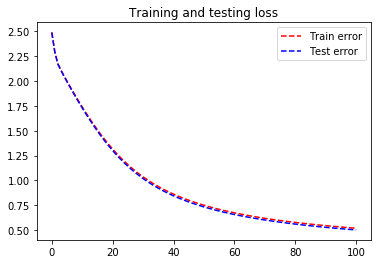

Epoch: 110, error: 0.4976023184358907, train accuracy: 0.8780333333333333, test accuracy: 0.8846
Epoch: 120, error: 0.4796718703343217, train accuracy: 0.8807, test accuracy: 0.8864
Epoch: 130, error: 0.46442912364207617, train accuracy: 0.8827333333333334, test accuracy: 0.8892
Epoch: 140, error: 0.45129857127890066, train accuracy: 0.8849833333333333, test accuracy: 0.8905
Epoch: 150, error: 0.43985767998809777, train accuracy: 0.8871833333333333, test accuracy: 0.8916
Epoch: 160, error: 0.4297893731112309, train accuracy: 0.8885833333333333, test accuracy: 0.8933
Epoch: 170, error: 0.42085120778169965, train accuracy: 0.8900333333333333, test accuracy: 0.8949
Epoch: 180, error: 0.41285475978696257, train accuracy: 0.8915, test accuracy: 0.8959
Epoch: 190, error: 0.40565146650035566, train accuracy: 0.8924833333333333, test accuracy: 0.8975
Epoch: 200, error: 0.3991226805783459, train accuracy: 0.8934333333333333, test accuracy: 0.8984


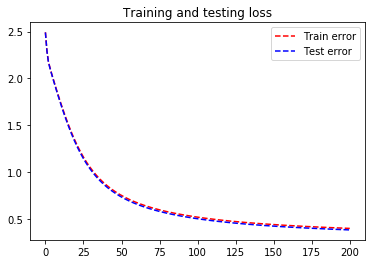

Epoch: 210, error: 0.39317254242747446, train accuracy: 0.8943333333333333, test accuracy: 0.8992
Epoch: 220, error: 0.38772278344685346, train accuracy: 0.8952, test accuracy: 0.9002
Epoch: 230, error: 0.3827088786022592, train accuracy: 0.8962333333333333, test accuracy: 0.9012
Epoch: 240, error: 0.37807715876876646, train accuracy: 0.8970666666666667, test accuracy: 0.902
Epoch: 250, error: 0.37378261650698347, train accuracy: 0.8978, test accuracy: 0.9024
Epoch: 260, error: 0.3697872199026722, train accuracy: 0.8983666666666666, test accuracy: 0.9024
Epoch: 270, error: 0.3660586033837031, train accuracy: 0.8991, test accuracy: 0.9033
Epoch: 280, error: 0.3625690414850021, train accuracy: 0.8997833333333334, test accuracy: 0.9048
Epoch: 290, error: 0.3592946372388004, train accuracy: 0.90025, test accuracy: 0.9054
Epoch: 300, error: 0.35621467496019005, train accuracy: 0.90105, test accuracy: 0.9054


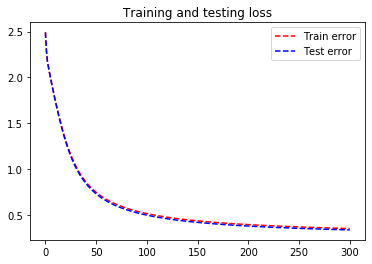

Epoch: 310, error: 0.35331110009968475, train accuracy: 0.9016333333333333, test accuracy: 0.9063
Epoch: 320, error: 0.350568098145076, train accuracy: 0.9023, test accuracy: 0.9065
Epoch: 330, error: 0.3479717513479294, train accuracy: 0.9027333333333334, test accuracy: 0.9067
Epoch: 340, error: 0.34550975705682996, train accuracy: 0.9033, test accuracy: 0.9071
Epoch: 350, error: 0.34317119516449934, train accuracy: 0.9040333333333334, test accuracy: 0.9075
Epoch: 360, error: 0.34094633497183946, train accuracy: 0.9044666666666666, test accuracy: 0.9083
Epoch: 370, error: 0.3388264738878388, train accuracy: 0.90485, test accuracy: 0.9088
Epoch: 380, error: 0.3368038019980341, train accuracy: 0.9052333333333333, test accuracy: 0.9088
Epoch: 390, error: 0.3348712877740237, train accuracy: 0.90555, test accuracy: 0.9094
Epoch: 400, error: 0.33302258115569483, train accuracy: 0.9060833333333334, test accuracy: 0.9102


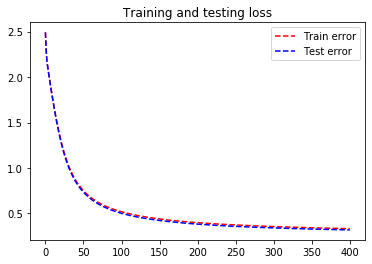

Epoch: 410, error: 0.3312519309847328, train accuracy: 0.9066, test accuracy: 0.911
Epoch: 420, error: 0.3295541143532922, train accuracy: 0.9069333333333334, test accuracy: 0.9111
Epoch: 430, error: 0.32792437589308226, train accuracy: 0.9073833333333333, test accuracy: 0.9113
Epoch: 440, error: 0.32635837539589857, train accuracy: 0.9078333333333334, test accuracy: 0.9118
Epoch: 450, error: 0.32485214244817534, train accuracy: 0.9081666666666667, test accuracy: 0.9129
Epoch: 460, error: 0.3234020369957441, train accuracy: 0.9084666666666666, test accuracy: 0.913
Epoch: 470, error: 0.32200471494307314, train accuracy: 0.9086833333333333, test accuracy: 0.9134
Epoch: 480, error: 0.3206570980434639, train accuracy: 0.9091333333333333, test accuracy: 0.9138
Epoch: 490, error: 0.31935634746037894, train accuracy: 0.9095833333333333, test accuracy: 0.9143
Epoch: 500, error: 0.31809984048107853, train accuracy: 0.91015, test accuracy: 0.9144


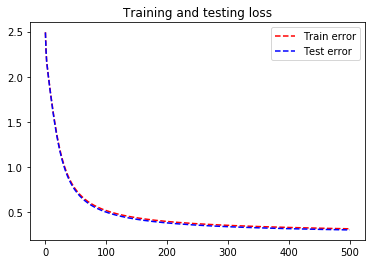

Epoch: 510, error: 0.31688514994656053, train accuracy: 0.91025, test accuracy: 0.9146
Epoch: 520, error: 0.3157100260299873, train accuracy: 0.9105, test accuracy: 0.9153
Epoch: 530, error: 0.31457238005215943, train accuracy: 0.9108333333333334, test accuracy: 0.9154
Epoch: 540, error: 0.3134702700693852, train accuracy: 0.9111166666666667, test accuracy: 0.9158
Epoch: 550, error: 0.3124012126645584, train accuracy: 0.9116166666666666, test accuracy: 0.9157
Epoch: 560, error: 0.31136409064134873, train accuracy: 0.9119666666666667, test accuracy: 0.9158


In [20]:
W, b = create_weights(architecture)

W, b, errors, acc_train, acc_test = train(X_train, y_train, X_test, y_test, 10, W, b, f, _lambda=0, alpha=0.5, max_delta_error=1e-4)

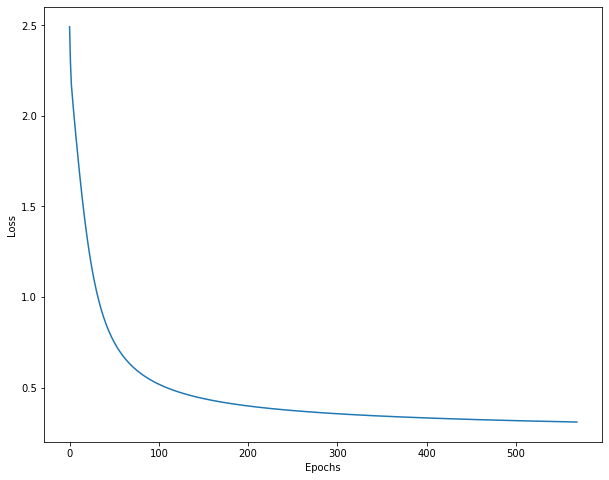

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(errors, label='Loss on train DS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

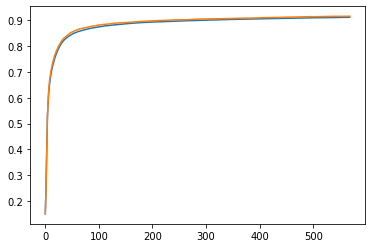

In [22]:
# acc_train, acc_test
plt.plot(acc_train, label='Acc train')
plt.plot(acc_test, label='Acc test')

# Test model

In [23]:
print(f'Accuracy on test set: {accuracy(X_test, y_test, W, b, f)}')

Accuracy on test set: 0.9161


In [25]:
#vis.close(env='main')